# Time Series Price Vegetables and Fruits

- Data Cleaning & EDA
- Data Preprocessing
- Modelling & Evaluation
- Optimization
- Deployment

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from keras.models import load_model

from datetime import datetime, timedelta

In [70]:
df = pd.read_csv('/content/drive/MyDrive/Projects/time-series-price-vegetables-fruits/kalimati_tarkari_dataset.csv')
df

,SN,Commodity,Date,Unit,Minimum,Maximum,Average
0,0,Tomato Big(Nepali),2013-06-16,Kg,35.0,40.0,37.5
1,1,Tomato Small(Local),2013-06-16,Kg,26.0,32.0,29.0
2,2,Potato Red,2013-06-16,Kg,20.0,21.0,20.5
3,3,Potato White,2013-06-16,Kg,15.0,16.0,15.5
4,4,Onion Dry (Indian),2013-06-16,Kg,28.0,30.0,29.0
...,...,...,...,...,...,...,...
197156,197156,Garlic Dry Nepali,2021-05-13,Kg,100.0,120.0,110.0
197157,197157,Fish Fresh(Rahu),2021-05-13,KG,270.0,280.0,275.0
197158,197158,Fish Fresh(Bachuwa),2021-05-13,KG,225.0,235.0,230.0
197159,197159,Fish Fresh(Chhadi),2021-05-13,KG,220.0,230.0,225.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197161 entries, 0 to 197160
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   SN         197161 non-null  int64  
 1   Commodity  197161 non-null  object 
 2   Date       197161 non-null  object 
 3   Unit       197161 non-null  object 
 4   Minimum    197161 non-null  float64
 5   Maximum    197161 non-null  float64
 6   Average    197161 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 10.5+ MB


In [ ]:
df.describe()

,SN,Minimum,Maximum,Average
count,197161.000000,197161.000000,197161.000000,197161.000000
mean,98580.000000,85.423938,94.161284,89.792611
std,56915.622549,77.058896,82.375858,79.619003
min,0.000000,1.000000,6.000000,5.000000
25%,49290.000000,40.000000,45.000000,42.500000
50%,98580.000000,60.000000,70.000000,65.000000
75%,147870.000000,100.000000,110.000000,105.000000
max,197160.000000,1800.000000,2000.000000,1900.000000


In [ ]:
df.isnull().sum()

,0
SN,0
Commodity,0
Date,0
Unit,0
Minimum,0
Maximum,0
Average,0


In [ ]:
df.duplicated().sum()

0

### Data Cleansing

In [71]:
#drop column that no needed
df = df.drop(columns = 'SN', axis=1)

#renaming columns
df = df.rename(columns = {'Commodity' : 'commodity'
, 'Date' : 'date', 'Unit' : 'unit', 'Minimum': 'min', 'Maximum':'max', 'Average' : 'avg'})

#change data type to datetime type
df['date'] = pd.to_datetime(df['date'])

#change unit
df['unit'].replace('KG', 'Kg', inplace = True)
df['unit'].replace('1 Pc', 'Pc',inplace = True)

In [ ]:
df.to_csv('/content/cleaned_market_sales.csv',index=False)

### Getting Data
tomato, potato, onion, fish, chilli, orange, mango

In [72]:
def to_df(df,food) :
  df = df.copy()
  df_food = df[df['commodity'] == food].reset_index(drop=True)
  return df_food

In [73]:
#query specific commodity
df_tomato = to_df(df, 'Tomato Small(Local)')
df_onion = to_df(df, 'Onion Dry (Indian)')
df_banana = to_df(df, 'Banana')
df_leaf = to_df(df, 'Brd Leaf Mustard')
df_ginger = to_df(df, 'Ginger')

In [78]:
def series_df(data) :
  data = data.set_index('date').drop(columns = ['commodity', 'unit', 'min', 'max']).sort_values(by='date')
  return data

tomato_series = series_df(df_tomato)
onion_series = series_df(df_onion)
banana_series = series_df(df_banana)
leaf_series = series_df(df_leaf)
ginger_series = series_df(df_ginger)
data_series = series_df(df)

## EDA

In [ ]:
total_sales = sum(df['avg'])
print(total_sales)

17703601.0


In [ ]:
total_min_sales = sum(df['min'])
total_max_sales = sum(df['max'])

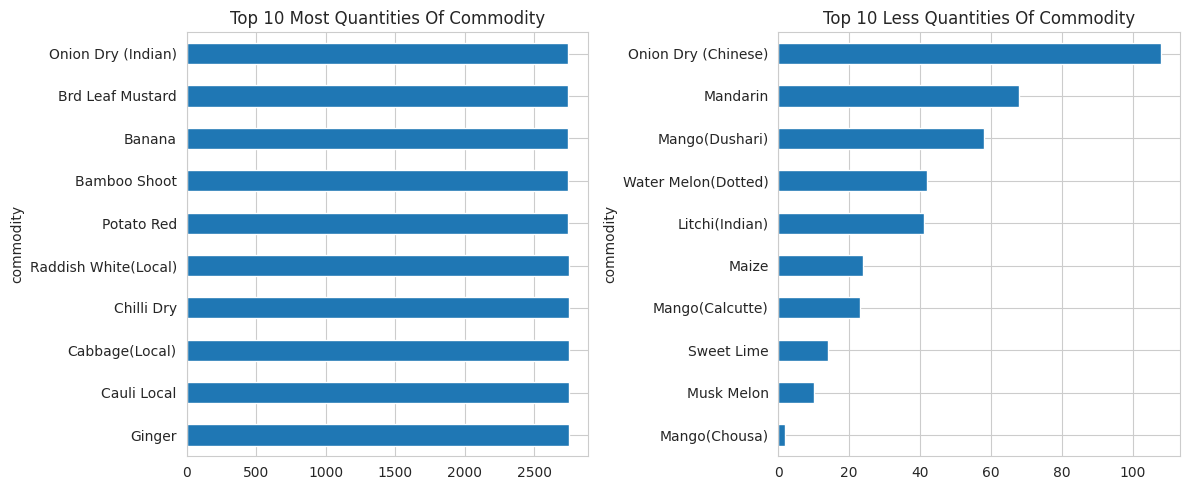

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

df['commodity'].value_counts().head(10).plot(kind='barh', title = 'Top 10 Most Quantities Of Commodity', ax=ax[0])
df['commodity'].value_counts().tail(10).plot(kind='barh', title = 'Top 10 Less Quantities Of Commodity', ax=ax[1])
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()

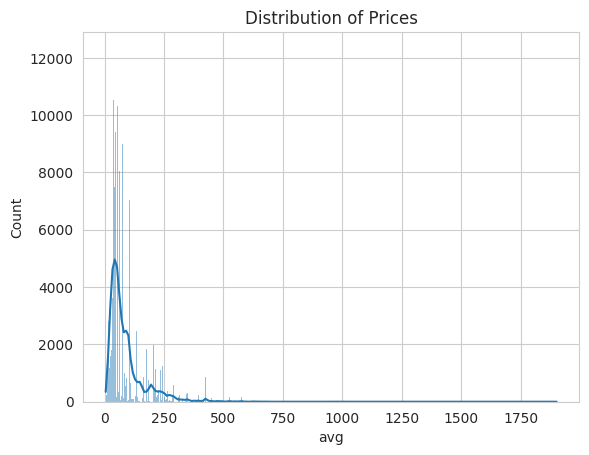

In [ ]:
sns.histplot(data=df['avg'], kde=True)
plt.title('Distribution of Prices')
plt.show()

#### **Insight** :
- There is significant price variation.
- The majority of prices are below 250, indicating that most commodities sold are within an affordable price range, reflecting market conditions where supply and demand are predominantly driven by lower-priced commodities.
- Some commodities have higher prices

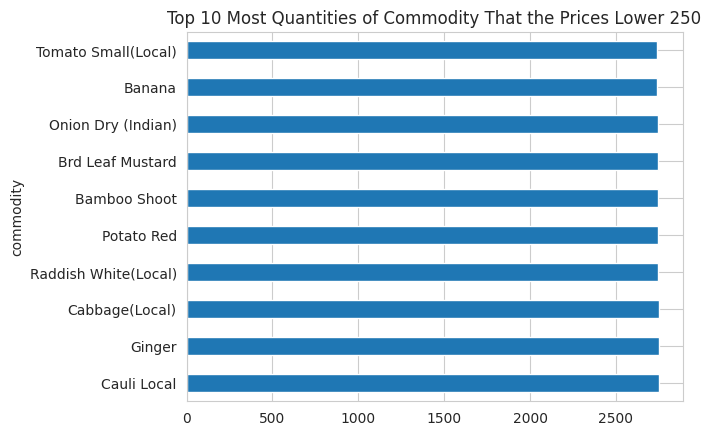

In [ ]:
df[df['avg'] < 250].value_counts('commodity').head(10).plot(kind='barh')
plt.title('Top 10 Most Quantities of Commodity That the Prices Lower 250')
plt.show()

In [ ]:
df[df['avg'] < 250].value_counts('commodity').head(10)

commodity
Cauli Local             2750
Ginger                  2749
Cabbage(Local)          2749
Raddish White(Local)    2747
Potato Red              2746
Bamboo Shoot            2743
Brd Leaf Mustard        2742
Onion Dry (Indian)      2742
Banana                  2741
Tomato Small(Local)     2741
Name: count, dtype: int64

#### **Insight** :
Top 10 commodity with high demand and supply of commodity where the price is low

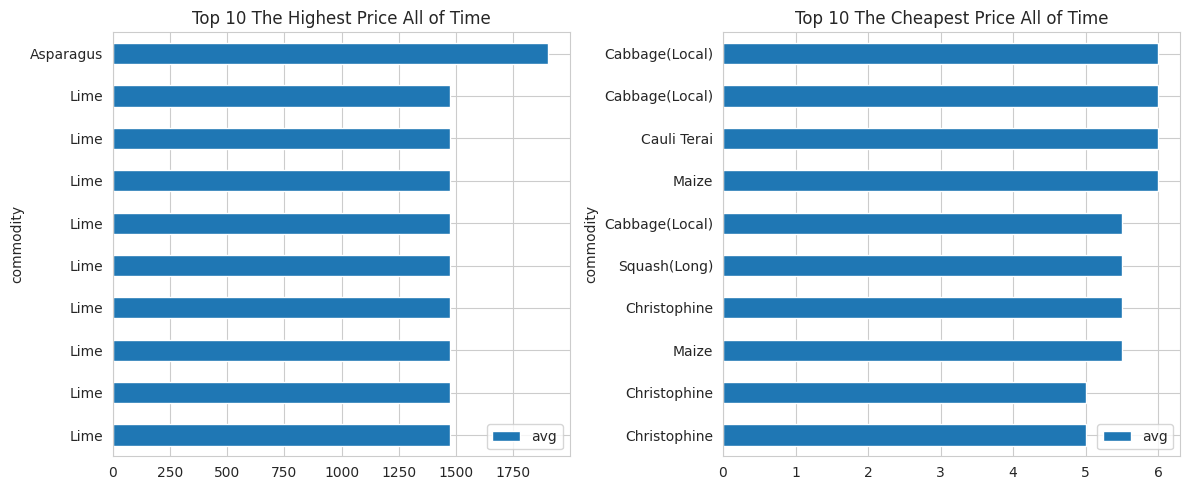

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
df.drop_duplicates(keep='last').nlargest(10, 'avg')[['commodity','avg']].plot(kind='barh', x='commodity', title='Top 10 The Highest Price All of Time', ax=ax[0])
ax[0].invert_yaxis()

df.drop_duplicates(keep='last').nsmallest(10, 'avg')[['commodity','avg']].plot(kind='barh', x='commodity', title='Top 10 The Cheapest Price All of Time', ax=ax[1])
plt.tight_layout()

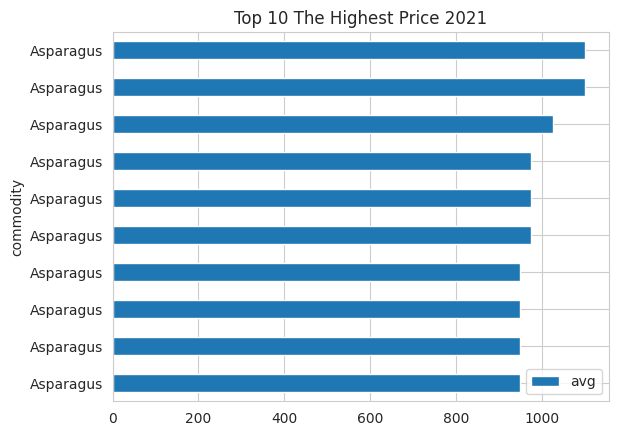

In [ ]:
df[df['date'].dt.year == 2021].nlargest(10,'avg')[['commodity','avg']].plot(kind='barh', x= 'commodity', title='Top 10 The Highest Price 2021')
plt.gca().invert_yaxis()

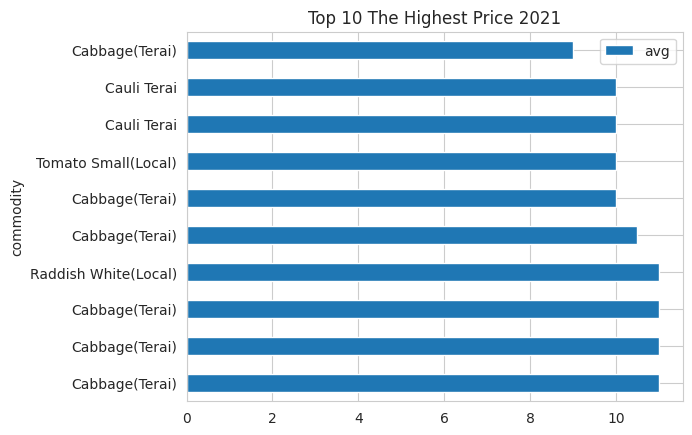

In [ ]:
df[df['date'].dt.year == 2021].nsmallest(10,'avg')[['commodity','avg']].plot(kind='barh', x= 'commodity', title='Top 10 The Highest Price 2021')
plt.gca().invert_yaxis()

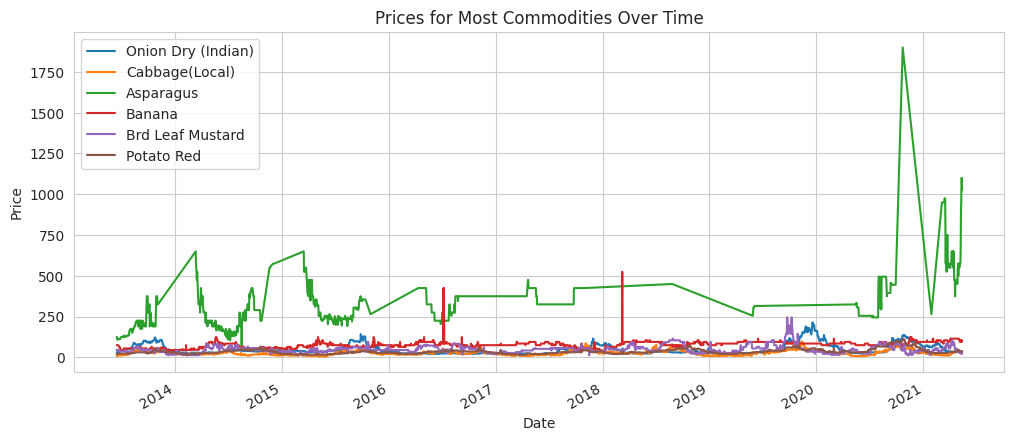

In [ ]:
fig,ax = plt.subplots(figsize=(12,5))

df[df['commodity'] == 'Onion Dry (Indian)'].plot(x='date', y='avg',ax=ax, label='Onion Dry (Indian)')
df[df['commodity'] == 'Cabbage(Local)'].plot(x='date', y='avg',ax=ax, label='Cabbage(Local)')
df[df['commodity'] == 'Asparagus'].plot(x='date', y='avg',ax=ax, label='Asparagus')
df[df['commodity'] == 'Banana'].plot(x='date', y='avg',ax=ax, label='Banana')
df[df['commodity'] == 'Brd Leaf Mustard'].plot(x='date', y='avg',ax=ax, label='Brd Leaf Mustard')
df[df['commodity'] == 'Potato Red'].plot(x='date', y='avg',ax=ax, label='Potato Red')

ax.set_title('Prices for Most Commodities Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.show()

In [ ]:
tail_commodity = df['commodity'].value_counts().tail(10).reset_index()

In [ ]:
tail_commodities = ['Onion Dry (Chinese)', 'Mandarin', 'Mango(Dushari)',
       'Water Melon(Dotted)', 'Litchi(Indian)', 'Maize',
       'Mango(Calcutte)', 'Sweet Lime', 'Musk Melon', 'Mango(Chousa)']

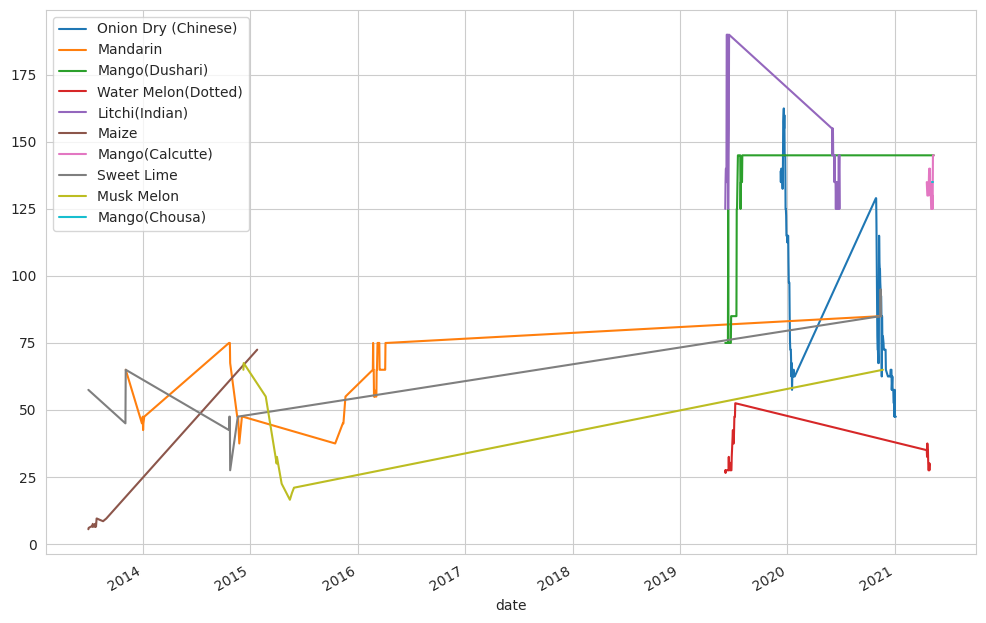

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

for commodity in tail_commodities :
  df[df['commodity'] == commodity].plot(x='date', y='avg', ax=ax,label=commodity)

#### **Insight**
The large supply of commodities is due to their low prices, as seen from the five commodities whose prices are significantly lower than Asparagus, which is a high-priced commodity with limited stock.

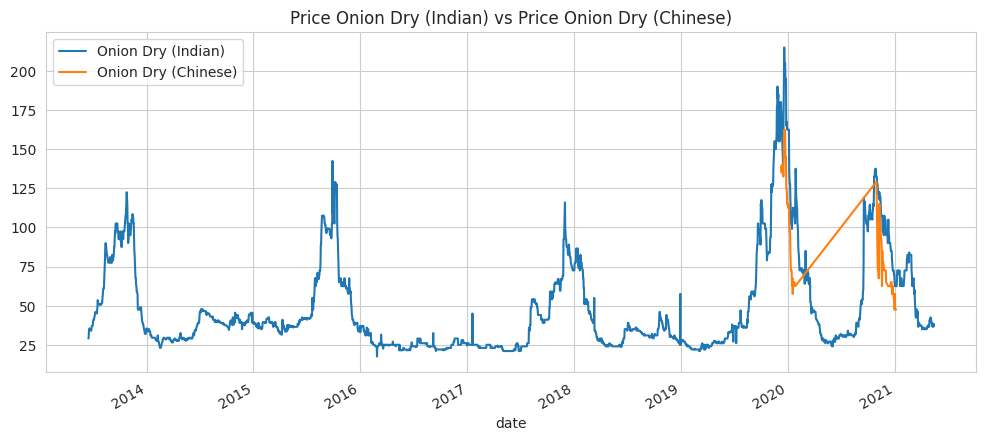

In [4]:
onion_dry = df[df['commodity'].str.contains('Onion Dry')]

fig,ax = plt.subplots(figsize=(12,5))

for onion in onion_dry['commodity'].unique() :
  df[df['commodity'] == onion].plot(x='date', y='avg',ax=ax, label=onion)

ax.set_title('Price Onion Dry (Indian) vs Price Onion Dry (Chinese)')
plt.show()

#### **Insight**
The price comparison between Onion Dry Indian and Onion Dry Chinese shows that their prices are not significantly different.

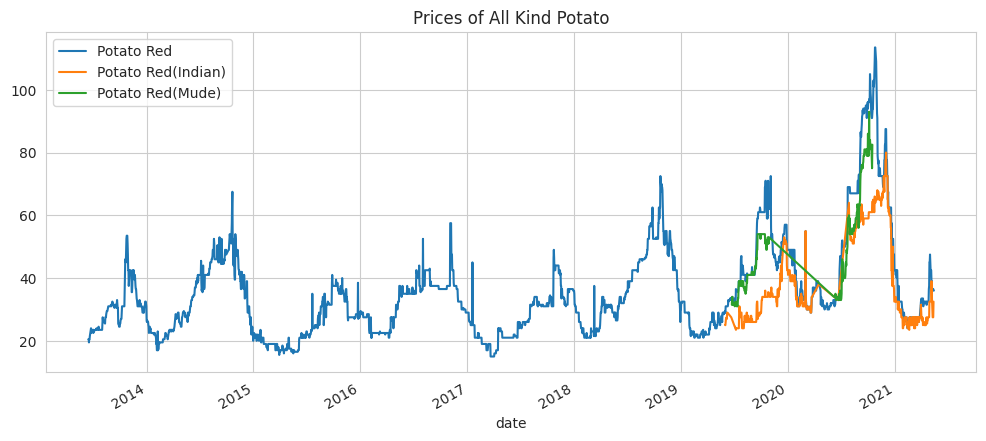

In [ ]:
potatoes = ['Potato Red','Potato Red(Indian)','Potato Red(Mude)']
fig, ax = plt.subplots(figsize=(12,5))

for potato in potatoes :
  df[df['commodity'] == potato].plot(x='date', y='avg',ax=ax, label=potato).plot

plt.title('Prices of All Kind Potato')
plt.show()

#### **Insight** :
- During the period when data for all types is available, prices for "Potato Red (Indian)" and "Potato Red (Mude)" tend to move in line with "Potato Red", but slightly lower.

- In 2020, there was a significant increase in prices for each type of potato and a decline in early 2021.

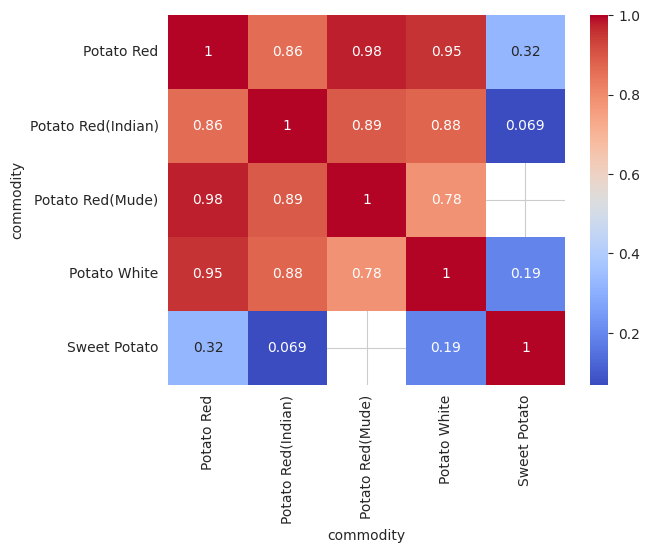

In [ ]:
potatoes_corr = df[df['commodity'].str.contains('Potato')].pivot_table(index='date', columns='commodity', values='avg').corr()
sns.heatmap(potatoes_corr, cmap='coolwarm', annot=True)
plt.show()

#### **Insight** :
- The prices of Potato Red, Indian Red Potato, Russet Potato, and Potato White show strong correlation.

In [ ]:
onions = df[df['commodity'].str.contains('Onion')]

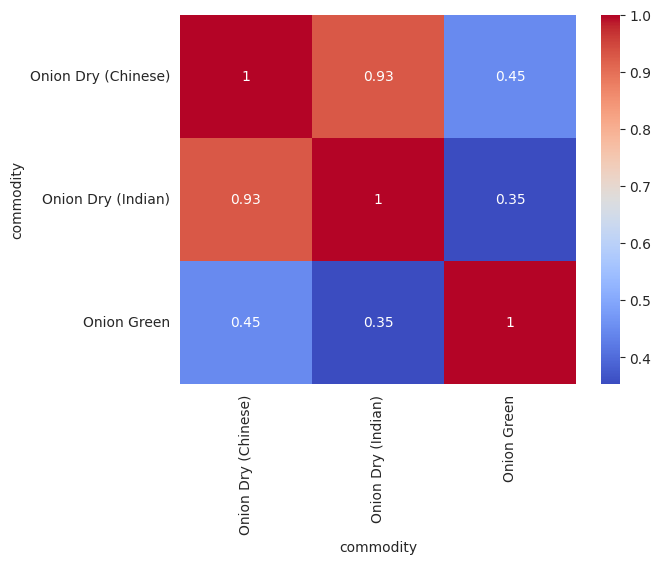

In [ ]:
onions_corr = onions.pivot_table(index='date', columns='commodity', values='avg').corr()
sns.heatmap(onions_corr, cmap='coolwarm', annot=True)
plt.show()

#### **Insight** :
- The prices of Onion Dry (Chinese) and Onion Dry (Indian) show strong correlation.

## Time Series Analysis
- Moving Avarage
- Decomposition - Trend, Seasonal, Residual(Noise)

In [ ]:
def plot_series(data, title) :
  fig,ax = plt.subplots(figsize=(12,5))
  data.plot(ax=ax, title=f'{title} Daily Prices 2014-2021')
  plt.show()

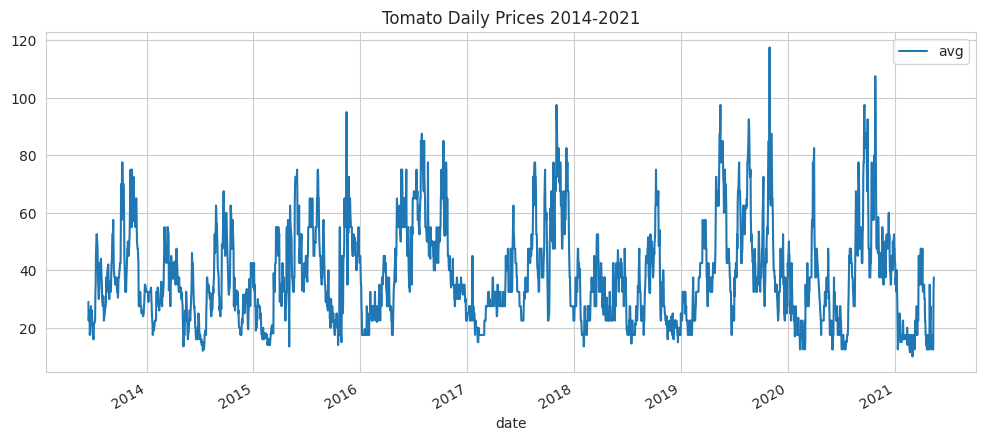

In [ ]:
plot_series(tomato_series,'Tomato')

In [ ]:
def moving_avg_30(data, title) :
  fig, ax = plt.subplots(figsize=(12,5))
  tomato_series.plot(ax = ax)
  tomato_series['avg'].rolling(window=1*30,
                                center = True,
                                ).mean().plot(ax = ax, linewidth=3, label='price')
  plt.title(f'{title} Prices 30 Days Moving Avarage')
  plt.show()

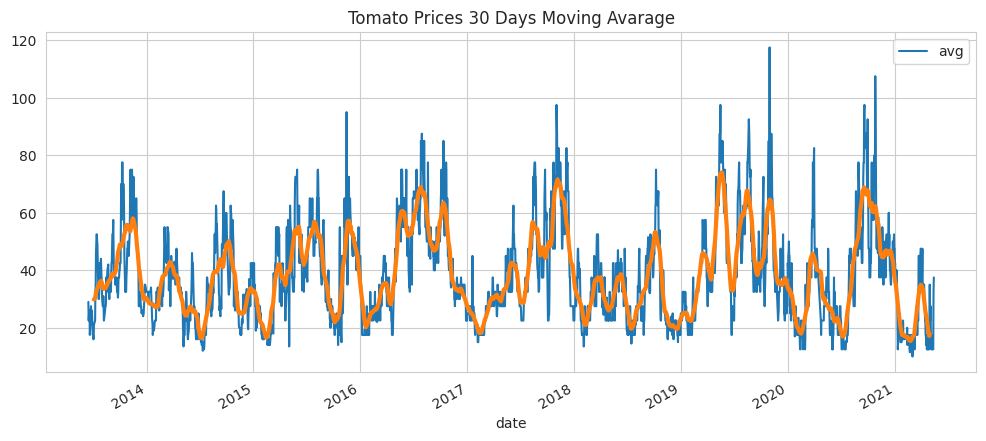

In [ ]:
moving_avg_30(tomato_series, 'Tomato')

#### Insight :
- Pola kenaikan dan penurunan harga terjadi hampir setiap tahun pada waktu yang hampir sama ditandai harga naik pada akhir tahun dan kembali turun di awal tahunnya
- Fluktuasi yang signifikan ada puncak yang tinggi dan lembah yang rendah
- Harga tomat cenderung tetap dalam rentang yang sama selama bertahun tehun dan tidak menunjukkan tren kenaikan atau penurunan jangka panjang yang jelas
- Terdapat beberapa periode harga tomat melonjak tajam sekitar tahun 2016, 2018, 2020

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

def data_decompose(data, title) :
  fig,ax = plt.subplots(2,2, figsize=(14,10))


  result = seasonal_decompose(data['avg'], model='additive', period=360)

  result.trend.plot(label='Trend',ax=ax[0,0],title='Trend')
  result.observed.plot(label = 'Observed', ax=ax[0,1], title='Observed')
  result.seasonal.plot(label='seasonal', ax=ax[1,0], title='Seasonal')
  result.resid.plot(label='residual', ax=ax[1,1], title='Residual')

  plt.suptitle(f'{title} Prices Decomposition')
  plt.legend()
  plt.tight_layout()
  plt.show()

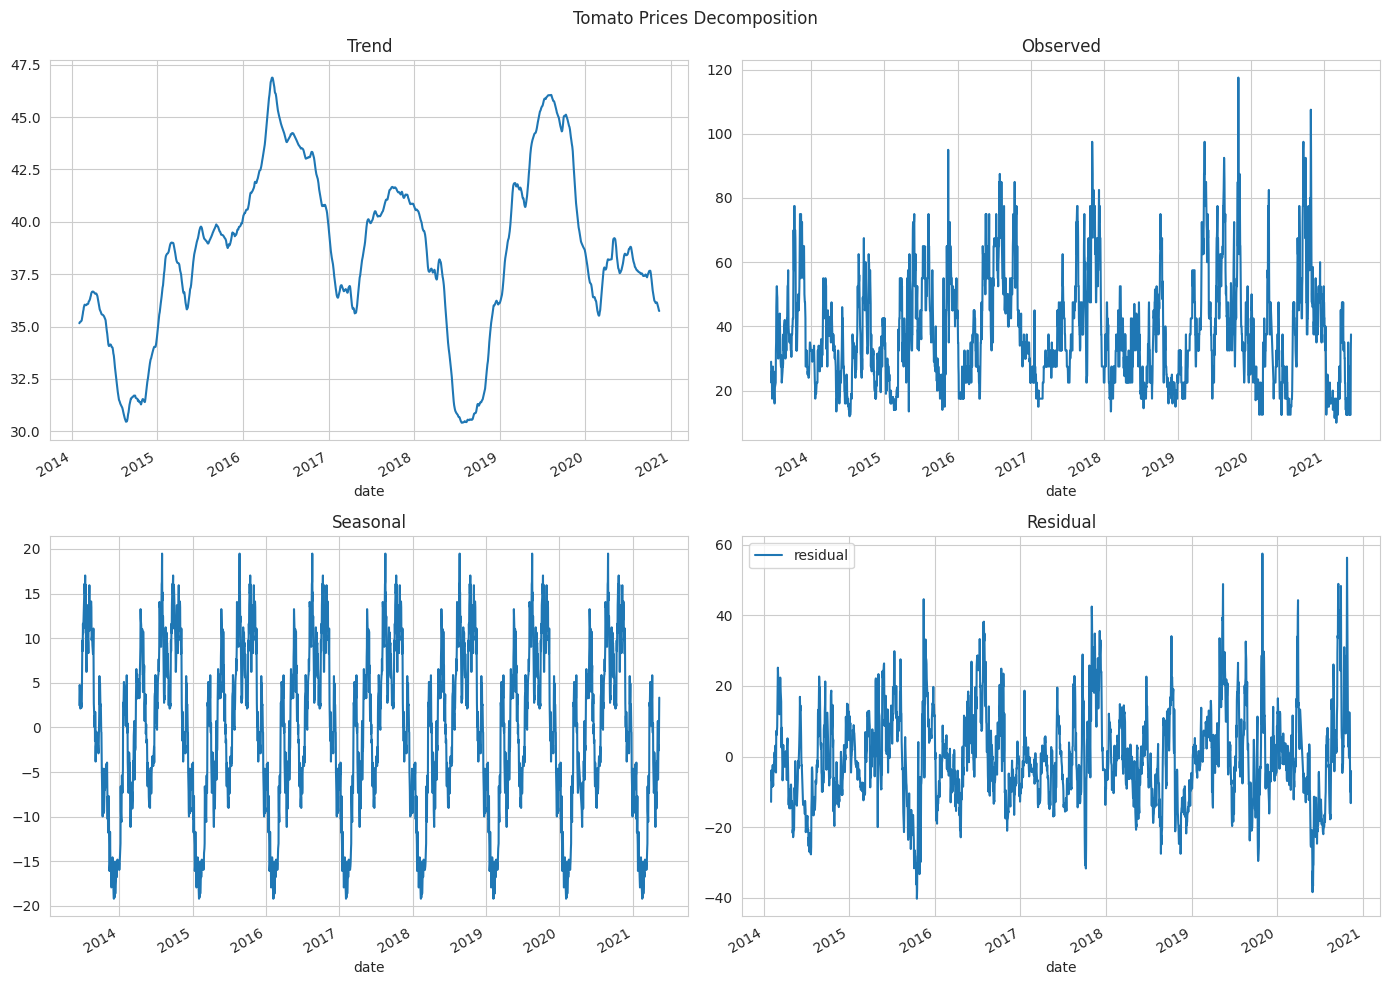

In [ ]:
data_decompose(tomato_series,'Tomato')

#### Insight
- Terdapat pola berulang yang sangat jelas terjadi di setiap 1 tahun
- Ada beberapa puncak residual yang sangat tinggi dan sangat rendah yang menunjukkan adanya anomali dalam harga tomat yang tidak dijelaskan oleh pola musiman atau tren jangka panjang

## Data Preprocessing

- Feature selection
- Train test split
- Normalize
- Additional features




In [ ]:
train_size = int(0.8 * len(tomato_series))
tomato_train = tomato_series[:train_size]
tomato_test = tomato_series[train_size:]

In [ ]:
def train_test_plot(train_data, test_data,title) :
  fig,ax = plt.subplots(figsize=(12,5))
  train_data.plot(ax=ax)
  test_data.plot(ax=ax)
  plt.title(f'{title} Train Test Data')
  plt.show()

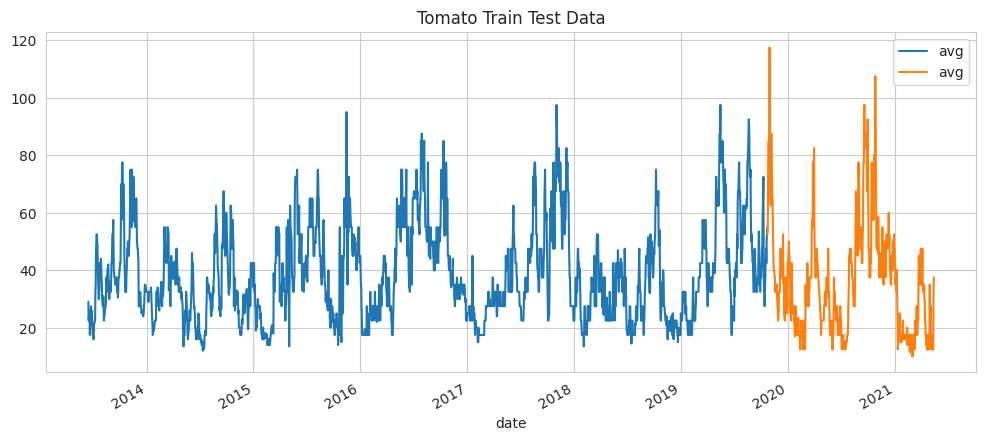

In [ ]:
train_test_plot(tomato_train, tomato_test, 'Tomato')

In [ ]:
def create_lstm_series(data, time_step=1) :
  X = []
  y = []
  for i in range(len(data) - time_step) :
    X.append(data[i : (time_step + i)])
    y.append(data[i + time_step])

  return np.array(X),np.array(y)

In [ ]:
time_step = 30

X_train, y_train = create_lstm_series(tomato_train['avg'], time_step)
X_test, y_test = create_lstm_series(tomato_test['avg'], time_step)

In [ ]:
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Modeling and Evaluation

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step,X_train_lstm.shape[2])))
lstm_model.add(LSTM(25, return_sequences=True))
lstm_model.add(LSTM(25, return_sequences = False))

lstm_model.add(Dense(25, activation='relu'))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 50)            10400     
                                                                 
 lstm_4 (LSTM)               (None, 30, 25)            7600      
                                                                 
 lstm_5 (LSTM)               (None, 25)                5100      
                                                                 
 dense_2 (Dense)             (None, 25)                650       
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 23776 (92.88 KB)
Trainable params: 23776 (92.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=64)

Epoch 1/100
34/34 [==============================] - 9s 44ms/step - loss: 1653.6835
Epoch 2/100
34/34 [==============================] - 2s 45ms/step - loss: 1339.9330
Epoch 3/100
34/34 [==============================] - 2s 44ms/step - loss: 1019.5252
Epoch 4/100
34/34 [==============================] - 2s 47ms/step - loss: 748.4985
Epoch 5/100
34/34 [==============================] - 2s 46ms/step - loss: 540.5569
Epoch 6/100
34/34 [==============================] - 2s 66ms/step - loss: 399.2927
Epoch 7/100
34/34 [==============================] - 3s 74ms/step - loss: 317.5843
Epoch 8/100
34/34 [==============================] - 2s 52ms/step - loss: 281.3801
Epoch 9/100
34/34 [==============================] - 2s 45ms/step - loss: 268.8572
Epoch 10/100
34/34 [==============================] - 2s 47ms/step - loss: 265.3616
Epoch 11/100
34/34 [==============================] - 2s 45ms/step - loss: 264.6028
Epoch 12/100
34/34 [==============================] - 2s 45ms/step - loss: 264.390

In [ ]:
y_pred_train = lstm_model.predict(X_train)
y_pred_test = lstm_model.predict(X_test)

17/17 [==============================] - 0s 15ms/step


In [ ]:
mse = mean_squared_error(y_test, y_pred_test)
mse

38.94192262530408

In [ ]:
y_test.shape, y_pred_test.shape

((489,), (489, 1))

In [ ]:
train_data.index[time_step:].shape, y_pred_train.shape

((2132,), (2132, 1))

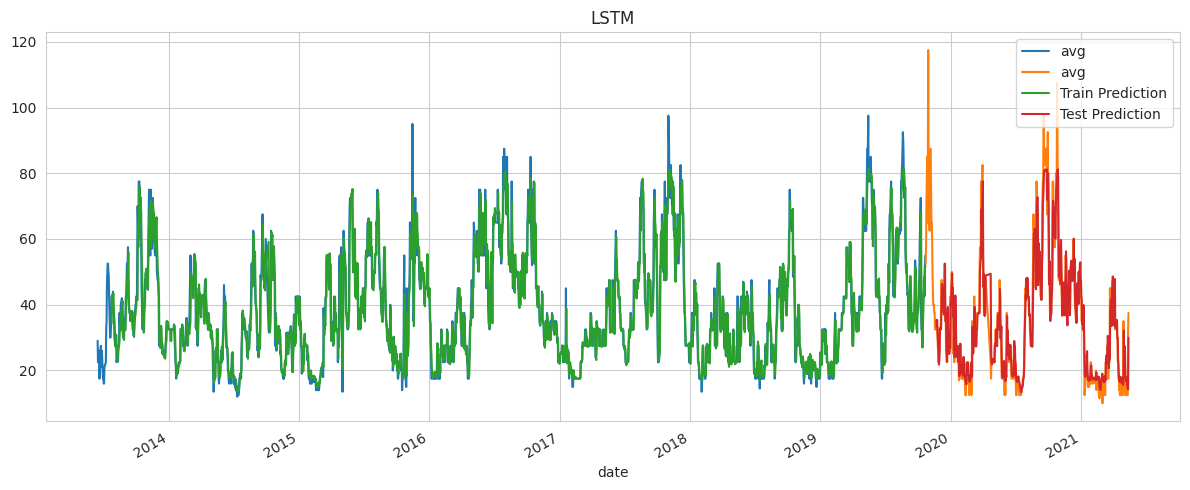

In [ ]:
fig,ax = plt.subplots(figsize=(12,5))

train_data.plot(ax=ax, label='Train')
test_data.plot(ax=ax, label='Test')
plt.plot(train_data.index[time_step:], y_pred_train, label='Train Prediction')
plt.plot(test_data.index[time_step:], y_pred_test, label='Test Prediction')
plt.title('LSTM')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Normalize Feature Data to Boost The Model Performance

In [ ]:
#normalize train-test data
scaler = StandardScaler()
tomato_train['avg_normalized'] = scaler.fit_transform(tomato_train[['avg']])
tomato_test['avg_normalized'] = scaler.transform(tomato_test[['avg']])

In [ ]:
def create_lstm_scaled(data,target, time_step=1) :
  X = []
  y = []
  for i in range(len(data) - time_step) :
    X.append(data[i : (time_step + i)])
    y.append(target[i + time_step])

  return np.array(X),np.array(y)

In [ ]:
time_step

30

In [ ]:
X_train_scaled, y_train = create_lstm_scaled(train_data['avg_normalized'].values, train_data['avg'].values, time_step)
X_test_scaled, y_test = create_lstm_scaled(test_data['avg_normalized'].values, test_data['avg'].values, time_step)

In [ ]:
X_train_scaled_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1],1))
X_test_scaled_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1],1))

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step,X_train_scaled_lstm.shape[2])))
lstm_model.add(LSTM(25, return_sequences=True))
lstm_model.add(LSTM(25, return_sequences = False))

lstm_model.add(Dense(25, activation='relu'))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
lstm_model.fit(X_train_scaled_lstm, y_train, epochs=100, batch_size=64)

Epoch 1/100
34/34 [==============================] - 8s 64ms/step - loss: 1707.4347
Epoch 2/100
34/34 [==============================] - 2s 73ms/step - loss: 1408.3339
Epoch 3/100
34/34 [==============================] - 2s 55ms/step - loss: 1075.6827
Epoch 4/100
34/34 [==============================] - 2s 46ms/step - loss: 798.8376
Epoch 5/100
34/34 [==============================] - 2s 45ms/step - loss: 571.4453
Epoch 6/100
34/34 [==============================] - 2s 46ms/step - loss: 405.9987
Epoch 7/100
34/34 [==============================] - 2s 44ms/step - loss: 317.2258
Epoch 8/100
34/34 [==============================] - 2s 45ms/step - loss: 279.0523
Epoch 9/100
34/34 [==============================] - 2s 50ms/step - loss: 267.5134
Epoch 10/100
34/34 [==============================] - 2s 73ms/step - loss: 264.9538
Epoch 11/100
34/34 [==============================] - 2s 74ms/step - loss: 264.6326
Epoch 12/100
34/34 [==============================] - 2s 45ms/step - loss: 264.701

In [ ]:
y_pred = lstm_model.predict(X_test_scaled)

17/17 [==============================] - 2s 3ms/step


In [ ]:
mse = mean_squared_error(y_test, y_pred)
mse

44.933590979270704

### Tomato Series Without Features Forecasting

In [ ]:
#series for lstm
def create_series_lstm(data, time_step=1) :
  X, y = [],[]
  for i in range(len(data)-time_step) :

    X.append(data[i : (i+time_step)])
    y.append(data[i + time_step])

  return np.array(X), np.array(y)

In [ ]:
train_size = int(len(tomato_series) * 0.8)
tomato_series_train = tomato_series[:train_size]
tomato_series_test = tomato_series[train_size:]

In [ ]:
time_step = 5
X_train_tomato, y_train_tomato = create_series_lstm(tomato_series_train['avg'], time_step)
X_test_tomato, y_test_tomato = create_series_lstm(tomato_series_test['avg'], time_step)

In [ ]:
X_train_tomato = X_train_tomato.reshape((X_train_tomato.shape[0], X_train_tomato.shape[1], 1))
X_test_tomato = X_test_tomato.reshape((X_test_tomato.shape[0], X_test_tomato.shape[1], 1))

<Axes: xlabel='date', ylabel='avg'>

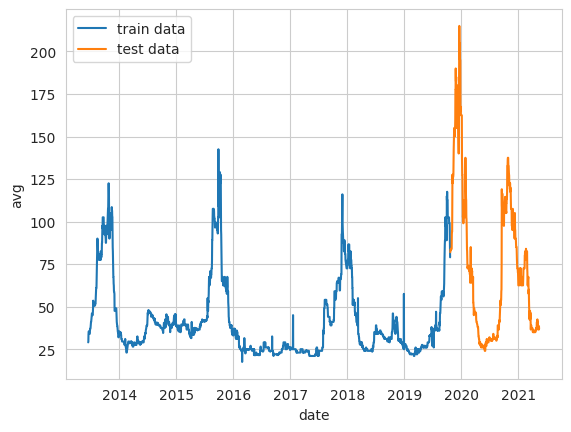

In [ ]:
sns.lineplot(tomato_series_train, x=train_data.index, y='avg', label='train data')
sns.lineplot(test_data, x=test_data.index, y='avg', label='test data')

In [ ]:
time_step = 4
X_train, y_train = create_series_lstm(train_data['avg'], time_step)
X_test, y_test = create_series_lstm(test_data['avg'], time_step)

In [ ]:
#reshape input for lstm

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

In [ ]:
len(onion_series[:train_size - time_step]),len(train_data) , len(y_train)

(2189, 2193, 2189)

In [ ]:
len(onion_series[train_size + time_step:]), len(test_data) , len(y_test)

(545, 549, 545)

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step,X_train_lstm.shape[2])))
lstm_model.add(LSTM(50, return_sequences = False))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

NameError: name 'Sequential' is not defined

In [ ]:
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 7, 50)             11400     
                                                                 
 lstm_10 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31651 (123.64 KB)
Trainable params: 31651 (123.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Training model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs = 100, batch_size=42)

Epoch 1/100
46/46 [==============================] - 5s 12ms/step - loss: 0.4004
Epoch 2/100
46/46 [==============================] - 1s 13ms/step - loss: 0.2140
Epoch 3/100
46/46 [==============================] - 1s 19ms/step - loss: 0.1782
Epoch 4/100
46/46 [==============================] - 1s 18ms/step - loss: 0.1528
Epoch 5/100
46/46 [==============================] - 1s 20ms/step - loss: 0.1521
Epoch 6/100
46/46 [==============================] - 1s 18ms/step - loss: 0.1353
Epoch 7/100
46/46 [==============================] - 1s 19ms/step - loss: 0.1379
Epoch 8/100
46/46 [==============================] - 1s 19ms/step - loss: 0.1275
Epoch 9/100
46/46 [==============================] - 1s 14ms/step - loss: 0.1238
Epoch 10/100
46/46 [==============================] - 1s 11ms/step - loss: 0.1156
Epoch 11/100
46/46 [==============================] - 1s 12ms/step - loss: 0.1293
Epoch 12/100
46/46 [==============================] - 1s 12ms/step - loss: 0.1240
Epoch 13/100
46/46 [=====

In [ ]:
train_predict = lstm_model.predict(X_train_lstm)
test_predict = lstm_model.predict(X_test_lstm)

15/15 [==============================] - 0s 12ms/step


In [ ]:
#mengembalikan normalisasi preidct data
train_predict = scaler_y.inverse_transform(train_predict)
test_predict = scaler_y.inverse_transform(test_predict)

In [ ]:
#mengembalikan normalisasi actual data
y_train_actual = scaler_y.inverse_transform(y_train_lstm)
y_test_actual = scaler_y.inverse_transform(y_test_lstm)

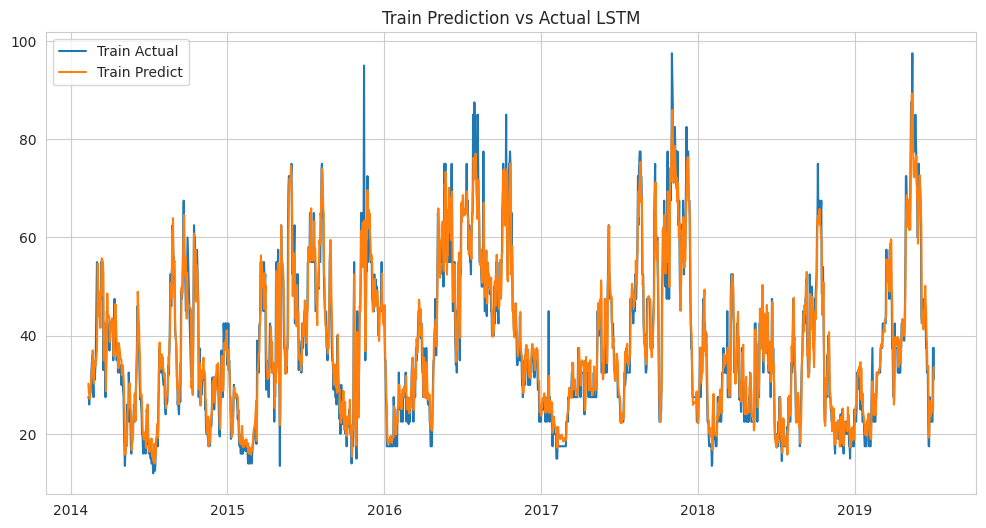

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index[time_step:], y_train_actual, label='Train Actual')
plt.plot(y_train.index[time_step:], train_predict, label='Train Predict')
plt.title('Train Prediction vs Actual LSTM')
plt.legend()
plt.show()

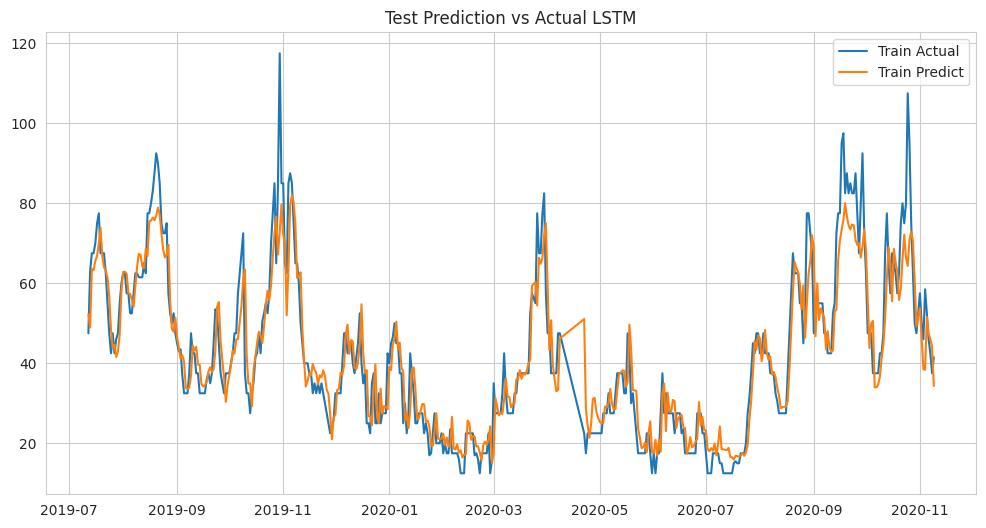

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[time_step:], y_test_actual, label='Train Actual')
plt.plot(y_test.index[time_step:], test_predict, label='Train Predict')
plt.title('Test Prediction vs Actual LSTM')
plt.legend()
plt.show()

In [ ]:
lstm_test_mse = mean_squared_error(y_test_actual, test_predict)
lstm_test_rmse = np.sqrt(lstm_test_mse)
print(f'LSTM MSE TEST DATA = {lstm_test_mse}')
print(f'LSTM MSE TEST DATA = {lstm_test_rmse}')

LSTM MSE TEST DATA = 58.35322571628619
LSTM MSE TEST DATA = 7.638928309408735


In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step,X_train_tomato.shape[2])))
lstm_model.add(LSTM(50, return_sequences = False))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
lstm_model.fit(X_train_tomato, y_train_tomato, batch_size=42, epochs = 100)

Epoch 1/100
53/53 [==============================] - 9s 8ms/step - loss: 1415.1112
Epoch 2/100
53/53 [==============================] - 0s 8ms/step - loss: 973.2333
Epoch 3/100
53/53 [==============================] - 0s 8ms/step - loss: 818.2114
Epoch 4/100
53/53 [==============================] - 0s 9ms/step - loss: 700.5515
Epoch 5/100
53/53 [==============================] - 0s 8ms/step - loss: 607.2208
Epoch 6/100
53/53 [==============================] - 0s 8ms/step - loss: 530.7396
Epoch 7/100
53/53 [==============================] - 0s 8ms/step - loss: 469.6508
Epoch 8/100
53/53 [==============================] - 0s 8ms/step - loss: 419.7395
Epoch 9/100
53/53 [==============================] - 0s 9ms/step - loss: 380.4981
Epoch 10/100
53/53 [==============================] - 0s 8ms/step - loss: 349.5491
Epoch 11/100
53/53 [==============================] - 0s 9ms/step - loss: 326.4699
Epoch 12/100
53/53 [==============================] - 0s 8ms/step - loss: 308.3876
Epoch 13/100

In [ ]:
y_pred_train = lstm_model.predict(X_train_tomato)
y_pred_test = lstm_model.predict(X_test_tomato)

17/17 [==============================] - 0s 7ms/step


In [ ]:
mse = mean_squared_error(y_test_tomato, y_pred_test)
mse

46.25284163673898

In [ ]:
mse = mean_squared_error(y_train_tomato, y_pred_train)
mse

30.123800554420278

DatetimeIndex(['2019-10-28', '2019-10-29', '2019-10-30', '2019-10-31',
               '2019-11-01', '2019-11-02', '2019-11-03', '2019-11-04',
               '2019-11-05', '2019-11-06',
               ...
               '2021-05-04', '2021-05-05', '2021-05-06', '2021-05-07',
               '2021-05-08', '2021-05-09', '2021-05-10', '2021-05-11',
               '2021-05-12', '2021-05-13'],
              dtype='datetime64[ns]', name='date', length=544, freq=None)

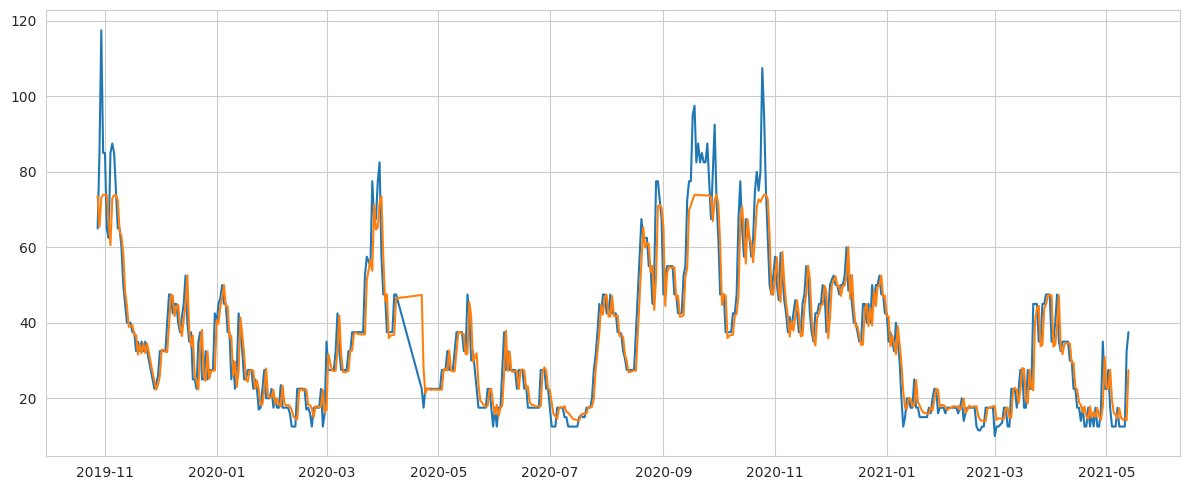

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(tomato_series_test.index[time_step:], y_test_tomato)
plt.plot(tomato_series_test.index[time_step:],y_pred_test)
plt.tight_layout()

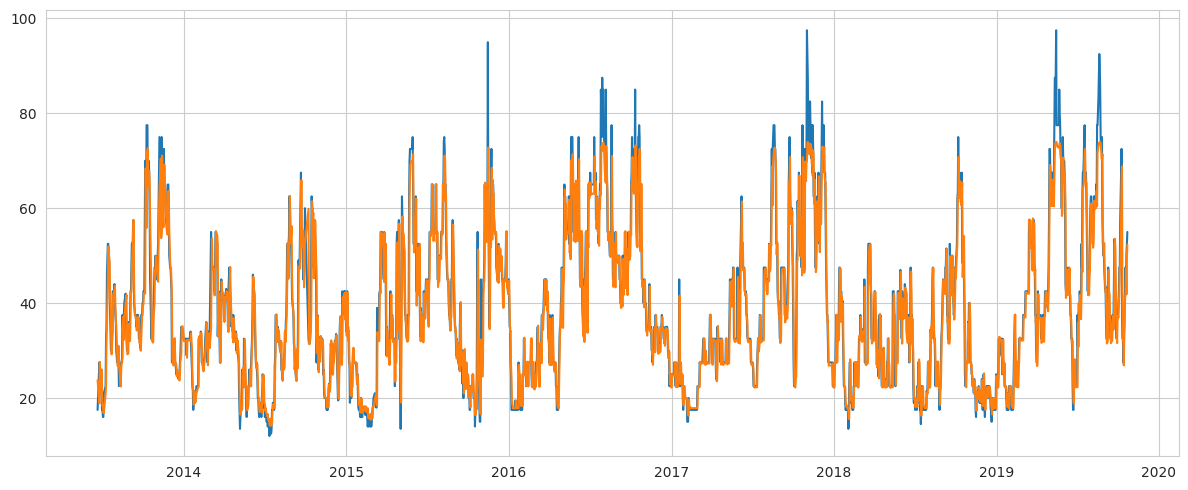

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(tomato_series_train.index[time_step:], y_train_tomato)
plt.plot(tomato_series_train.index[time_step:],y_pred_train)
plt.tight_layout()

## Onion Series LSTM

In [32]:
onion_series.to_csv('./onion_series.csv')

In [33]:
plot_series(onion_series, 'Onion')

NameError: name 'plot_series' is not defined

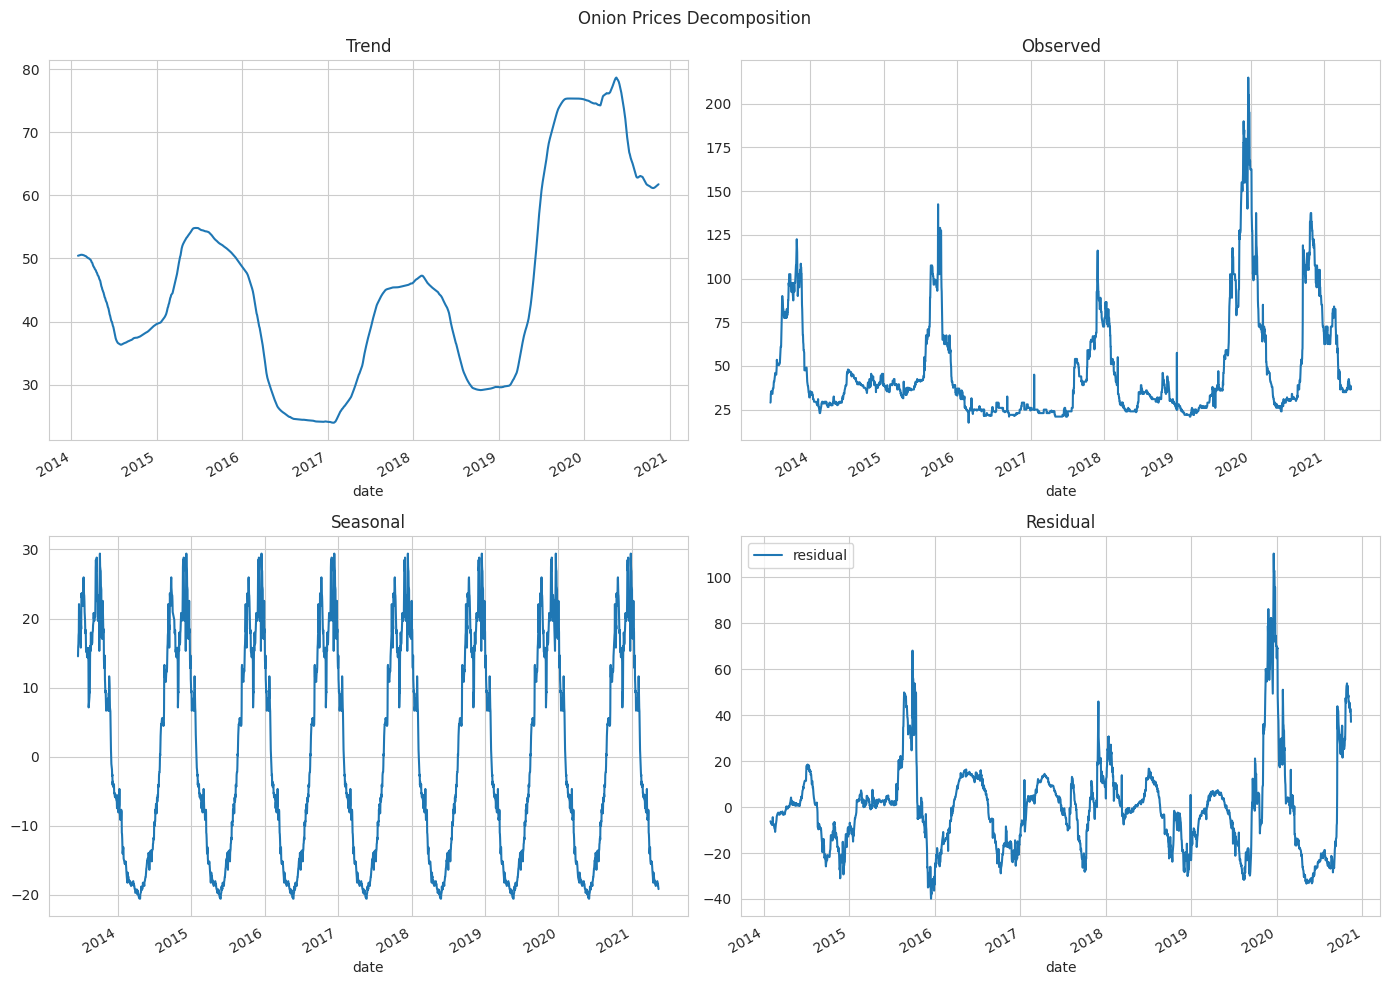

In [ ]:
data_decompose(onion_series,'Onion')

#### Insight :
- Adanya fluktuasi harga yang cukup besar dan beberapa puncak yang signifikan
- Harga cenderung meningkat dari tahun 2014 - 2015, kemudian terjadi penurunan harga tahun 2017 dan harga kembali naik hingga puncaknya pada tahun 2020, lalu menurun menjelang tahun 2021

### Data Preprocessing

In [34]:
train_size = int(0.8 * len(onion_series))
onion_train = onion_series[:train_size]
onion_test = onion_series[train_size:]

In [35]:
train_test_plot(onion_train, onion_test, 'Onion')

NameError: name 'train_test_plot' is not defined

In [36]:
#normalize data
scaler = MinMaxScaler(feature_range=(-1,1))

onion_train['scaled'] = scaler.fit_transform(onion_train[['avg']])
onion_test['scaled'] = scaler.transform(onion_test[['avg']])

In [40]:
time_step = 30
def create_lstm_data(data, target, time_step=1) :
  X = []
  y = []

  for i in range(len(data) - time_step) :
    X.append(data[i : (i+time_step)])
    y.append(target[i+time_step])

  return np.array(X), np.array(y)

In [41]:
# splitting data for lstm
X_train, y_train = create_lstm_data(onion_train['scaled'].values, onion_train['scaled'].values, time_step)
X_test, y_test = create_lstm_data(onion_test['scaled'].values, onion_test['scaled'].values, time_step)

In [42]:
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

### Build LSTM

In [43]:
# Membuat model LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(25, return_sequences=True))
lstm_model.add(LSTM(25, return_sequences=False))

lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=42, verbose=1)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.1598
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0159
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0114
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0102
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0096
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0078
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0081
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0084
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0067
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0063
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0062
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0057
Epoch 13/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0052
Epoch 14/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0049
Epoch 15/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - lo

In [50]:
y_pred_train_normalized = lstm_model.predict(X_train_lstm)
y_pred_normalized = lstm_model.predict(X_test_lstm)

68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [51]:
y_pred_train = scaler.inverse_transform(y_pred_train_normalized)
y_pred = scaler.inverse_transform(y_pred_normalized)

In [52]:
y_train_actual = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

In [53]:
mse = mean_squared_error(y_test_actual, y_pred)
mse

84.09433721950464

In [54]:
mse_train = mean_squared_error(y_train_actual, y_pred_train)
mse_train

7.51341061658896

### Plot Model Performance

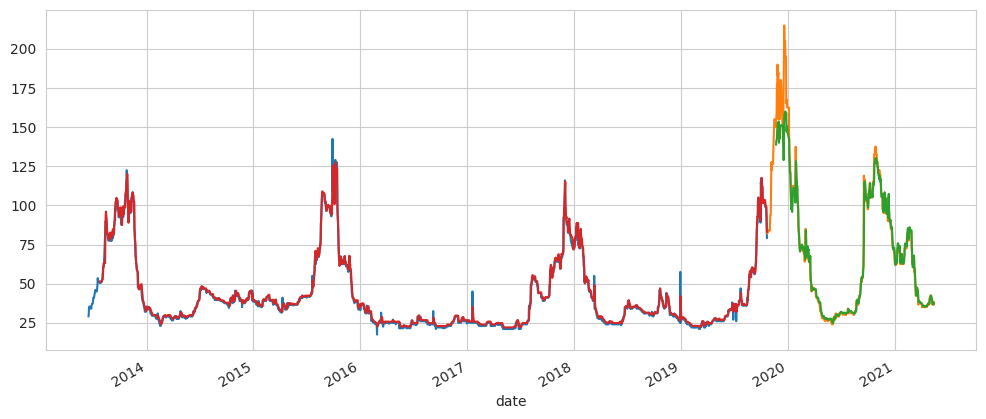

In [55]:
fig,ax = plt.subplots(figsize=(12,5))
onion_train['avg'].plot(ax=ax)
onion_test['avg'].plot(ax=ax)
ax.plot(onion_test.index[time_step:], y_pred, label='Test Prediction')
ax.plot(onion_train.index[time_step:], y_pred_train, label='Test Prediction')
plt.show()

### Save Model

In [56]:
lstm_model.save('./onion_lstm_model.h5')

In [57]:
onion_model = load_model('./onion_lstm_model.h5')

In [79]:
data = onion_series[-30:]

In [82]:
data_scaled = scaler.transform(data[['avg']])

In [86]:
data_reshape = data_scaled.reshape((1,30,1))

In [91]:
predictions = []

for i in range(30) :
  predicted_value = onion_model.predict(data_reshape)
  predicted_actual = scaler.inverse_transform(predicted_value)
  predictions.append(predicted_actual[0,0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━

30

In [101]:
start_date = onion_series.index[-1]
date = [start_date + timedelta(days = x) for x in range(1 , len(predictions) + 1)]

data_prediction = pd.DataFrame({
    'date' : date ,
    'prediction' : predictions
})

data_prediction

,date,prediction
0,2021-05-14,37.399841
1,2021-05-15,37.399841
2,2021-05-16,37.399841
3,2021-05-17,37.399841
4,2021-05-18,37.399841
5,2021-05-19,37.399841
6,2021-05-20,37.399841
7,2021-05-21,37.399841
8,2021-05-22,37.399841
9,2021-05-23,37.399841


## Banana Forecasting

In [ ]:
#deleting outliers
banana_series = banana_series[banana_series['avg'] < 150]

In [ ]:
train_size = int(len(banana_series)*0.8)

In [ ]:
train = banana_series[:train_size]
test = banana_series[train_size:]

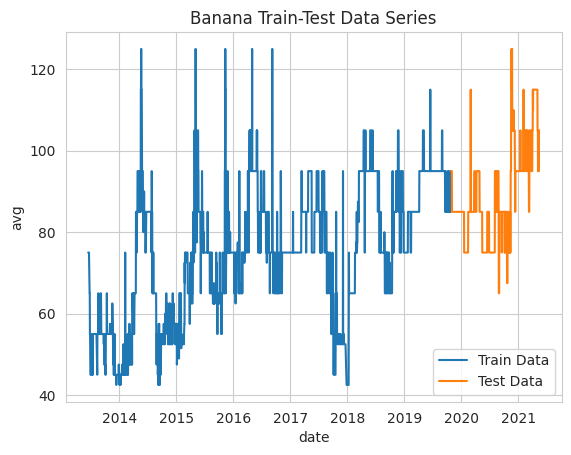

In [ ]:
sns.lineplot(train, x =train.index, y='avg', label='Train Data')
sns.lineplot(test, x=test.index, y='avg', label='Test Data')
plt.title('Banana Train-Test Data Series')
plt.legend()
plt.show()

In [ ]:
#transform data
scaler = StandardScaler()
train['scaled'] = scaler.fit_transform(train)
test['scaled'] = scaler.transform(test)

In [ ]:
def lstm_data(data, time_step=1) :
  X,y = [],[]

  for i in range(len(data) - time_step) :

    X.append(data[i : (i+time_step)])
    y.append(data[i + time_step])

  X = np.array(X)
  y = np.array(y)

  return X,y

In [ ]:
time_step = 30
X_train, y_train = lstm_data(train['scaled'].values, time_step)
X_test, y_test = lstm_data(test['scaled'].values, time_step)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

In [ ]:
# Membuat model LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(25, return_sequences=False))

lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model
lstm_model.fit(X_train, y_train, epochs=100, batch_size=42, verbose=1)

Epoch 1/100
52/52 [==============================] - 12s 29ms/step - loss: 0.3407
Epoch 2/100
52/52 [==============================] - 2s 30ms/step - loss: 0.1710
Epoch 3/100
52/52 [==============================] - 2s 46ms/step - loss: 0.1577
Epoch 4/100
52/52 [==============================] - 2s 46ms/step - loss: 0.1462
Epoch 5/100
52/52 [==============================] - 2s 34ms/step - loss: 0.1354
Epoch 6/100
52/52 [==============================] - 2s 37ms/step - loss: 0.1245
Epoch 7/100
52/52 [==============================] - 2s 33ms/step - loss: 0.1127
Epoch 8/100
52/52 [==============================] - 2s 35ms/step - loss: 0.1050
Epoch 9/100
52/52 [==============================] - 2s 37ms/step - loss: 0.1034
Epoch 10/100
52/52 [==============================] - 3s 61ms/step - loss: 0.0953
Epoch 11/100
52/52 [==============================] - 4s 69ms/step - loss: 0.0956
Epoch 12/100
52/52 [==============================] - 3s 52ms/step - loss: 0.0966
Epoch 13/100
52/52 [====

In [ ]:
#y_train and y_test predict in normalized
y_train_predict = lstm_model.predict(X_train)
y_test_predict = lstm_model.predict(X_test)

17/17 [==============================] - 1s 24ms/step


In [ ]:
#inverse transform
y_train_predict = scaler.inverse_transform(y_train_predict)
y_pred = scaler.inverse_transform(y_test_predict)

In [ ]:
#inverse transform actual data and reshape
y_train_actual = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
mse_test = mean_squared_error(y_test_actual, y_pred)

In [ ]:
mse_test

27.849782331924715

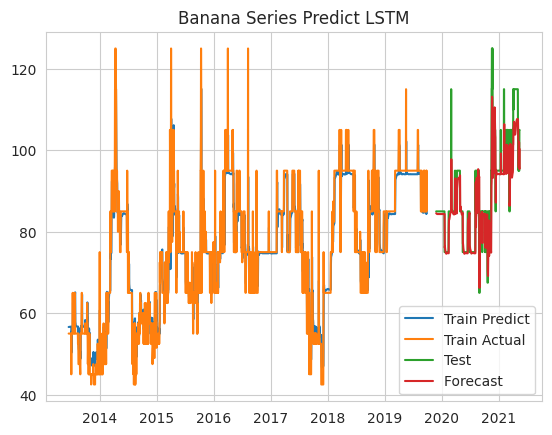

In [ ]:
plt.plot(banana_series.index[:train_size - time_step], y_train_predict, label='Train Predict')
plt.plot(banana_series.index[:train_size - time_step], y_train_actual, label='Train Actual')
plt.plot(banana_series.index[train_size + time_step:], y_test_actual, label='Test')
plt.plot(banana_series.index[train_size + time_step:], y_pred, label='Forecast ')
plt.title('Banana Series Predict LSTM')
plt.legend()
plt.show()

## Leaf Forecasting

In [ ]:
train_size = int(len(leaf_series)*0.8)

In [ ]:
train_data = leaf_series[:train_size]
test_data = leaf_series[train_size:]

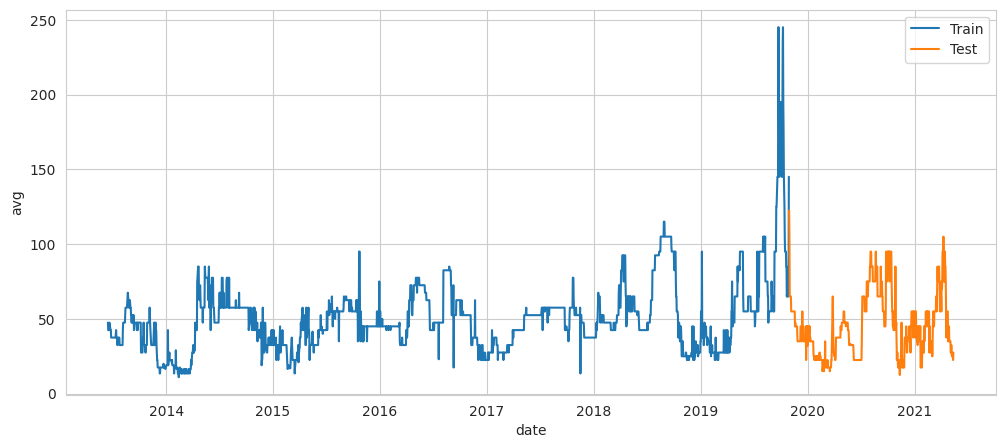

In [ ]:
fig,ax = plt.subplots(figsize=(12,5))
sns.lineplot(train_data, x=train_data.index, y='avg', label='Train')
sns.lineplot(test_data, x=test_data.index, y='avg', label='Test')
plt.show()

In [ ]:
scaler = StandardScaler()
train_data['avg'] = scaler.fit_transform(train_data[['avg']])
test_data['avg'] = scaler.transform(test_data[['avg']])

In [ ]:
#transform data for lstm model
time_step = 30
X_train, y_train = lstm_data(train_data['avg'], time_step)
X_test, y_test = lstm_data(test_data['avg'], time_step)

In [ ]:
#reshape data to array 3d
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Membuat model LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(25, return_sequences=False))

lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model
lstm_model.fit(X_train, y_train, epochs=100, batch_size=42, verbose=1)

Epoch 1/100
52/52 [==============================] - 8s 23ms/step - loss: 0.3454
Epoch 2/100
52/52 [==============================] - 1s 22ms/step - loss: 0.1693
Epoch 3/100
52/52 [==============================] - 1s 23ms/step - loss: 0.1471
Epoch 4/100
52/52 [==============================] - 1s 23ms/step - loss: 0.1360
Epoch 5/100
52/52 [==============================] - 1s 23ms/step - loss: 0.1299
Epoch 6/100
52/52 [==============================] - 3s 54ms/step - loss: 0.1223
Epoch 7/100
52/52 [==============================] - 2s 37ms/step - loss: 0.1168
Epoch 8/100
52/52 [==============================] - 2s 34ms/step - loss: 0.1109
Epoch 9/100
52/52 [==============================] - 1s 22ms/step - loss: 0.1009
Epoch 10/100
52/52 [==============================] - 1s 22ms/step - loss: 0.0984
Epoch 11/100
52/52 [==============================] - 1s 22ms/step - loss: 0.0916
Epoch 12/100
52/52 [==============================] - 1s 22ms/step - loss: 0.0899
Epoch 13/100
52/52 [=====

In [ ]:
#Predict with train and test data
y_pred_train = lstm_model.predict(X_train)
y_pred = lstm_model.predict(X_test)

17/17 [==============================] - 0s 10ms/step


In [ ]:
#inverse transform data
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred = scaler.inverse_transform(y_pred)

In [ ]:
# tranform normalized data to actual data
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

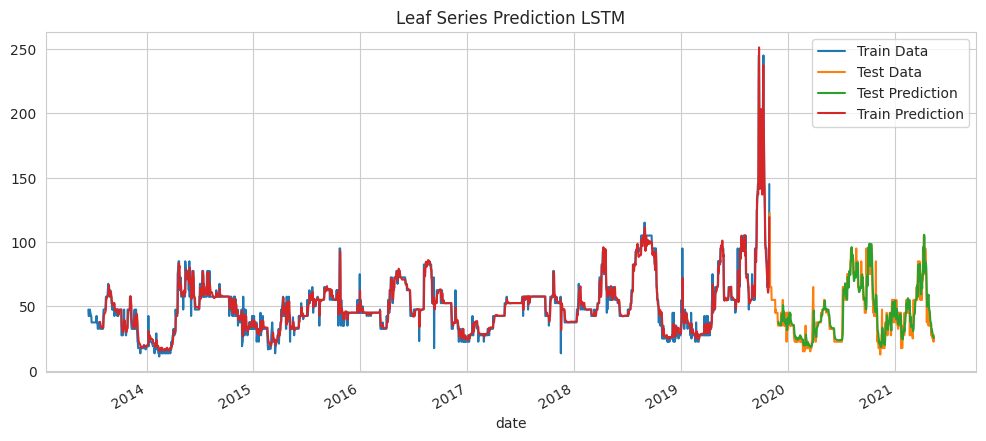

In [ ]:
fig,ax = plt.subplots(figsize=(12,5))
leaf_series['avg'][:train_size].plot(ax=ax, label='Train Data')
leaf_series['avg'][train_size:].plot(ax=ax, label='Test Data')
ax.plot(test_data.index[time_step:], y_pred, label='Test Prediction')
ax.plot(train_data.index[time_step:], y_pred_train, label='Train Prediction')
plt.title('Leaf Series Prediction LSTM')
plt.legend()
plt.show()

## Ginger Forecasting

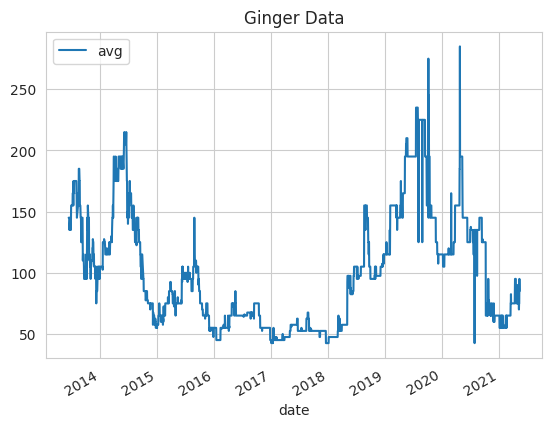

In [ ]:
ginger_series.plot(title='Ginger Data')
plt.show()

In [ ]:
# split train and test data
train_size = int(len(ginger_series) * 0.8)
ginger_train = ginger_series[:train_size]
ginger_test = ginger_series[train_size:]

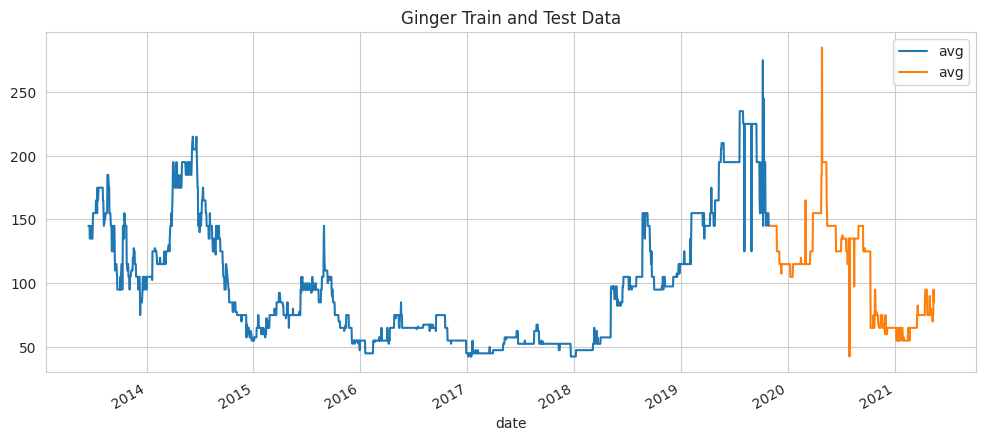

In [ ]:
fig,ax = plt.subplots(figsize=(12,5))
ginger_train.plot(ax=ax, label='Train Data')
ginger_test.plot(ax=ax, label='Test Data')
plt.title('Ginger Train and Test Data')
plt.legend()
plt.show()

In [ ]:
ginger_train['avg']= scaler.fit_transform(ginger_train[['avg']])
ginger_test['avg']= scaler.transform(ginger_test[['avg']])

In [ ]:
X_train, y_train = lstm_data(ginger_train['avg'], time_step)
X_test, y_test = lstm_data(ginger_test['avg'], time_step)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Membuat model LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(25, return_sequences=True))
lstm_model.add(LSTM(25, return_sequences=False))

lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model
lstm_model.fit(X_train, y_train, epochs=100, batch_size=42, verbose=1)

Epoch 1/100
52/52 [==============================] - 11s 34ms/step - loss: 0.2159
Epoch 2/100
52/52 [==============================] - 2s 35ms/step - loss: 0.0622
Epoch 3/100
52/52 [==============================] - 2s 33ms/step - loss: 0.0552
Epoch 4/100
52/52 [==============================] - 2s 34ms/step - loss: 0.0472
Epoch 5/100
52/52 [==============================] - 2s 39ms/step - loss: 0.0426
Epoch 6/100
52/52 [==============================] - 3s 54ms/step - loss: 0.0371
Epoch 7/100
52/52 [==============================] - 2s 44ms/step - loss: 0.0372
Epoch 8/100
52/52 [==============================] - 2s 34ms/step - loss: 0.0334
Epoch 9/100
52/52 [==============================] - 2s 33ms/step - loss: 0.0315
Epoch 10/100
52/52 [==============================] - 2s 34ms/step - loss: 0.0326
Epoch 11/100
52/52 [==============================] - 2s 33ms/step - loss: 0.0295
Epoch 12/100
52/52 [==============================] - 2s 32ms/step - loss: 0.0286
Epoch 13/100
52/52 [====

In [ ]:
y_pred_train = lstm_model.predict(X_train)
y_pred = lstm_model.predict(X_test)

17/17 [==============================] - 0s 14ms/step


In [ ]:
#inverse data
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred = scaler.inverse_transform(y_pred)

In [ ]:
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
mse_predict = mean_squared_error(y_test, y_pred)
mse_predict

0.03660813824266781

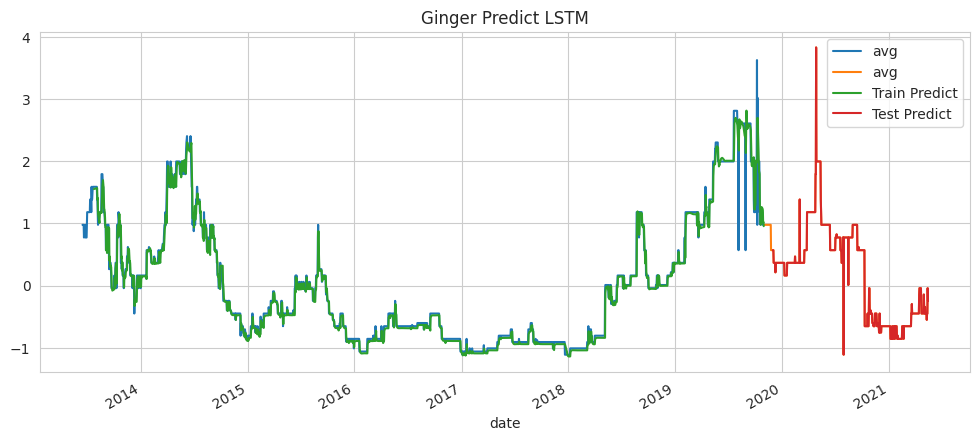

In [ ]:
fig,ax = plt.subplots(figsize=(12,5))
ginger_train.plot(ax=ax)
ginger_test.plot(ax=ax)
ax.plot(ginger_train.index[time_step:], y_pred_train, label='Train Predict')
ax.plot(ginger_test.index[time_step:], y_test, label='Test Predict')
plt.title('Ginger Predict LSTM')
plt.legend()
plt.show()

## Daily Sales Forecasting

In [ ]:
#grouping data by day with mean aggregation
data_series = data_series.groupby('date').mean('avg')

In [ ]:
data_series.to_csv('/content/daily_sales_data.csv')

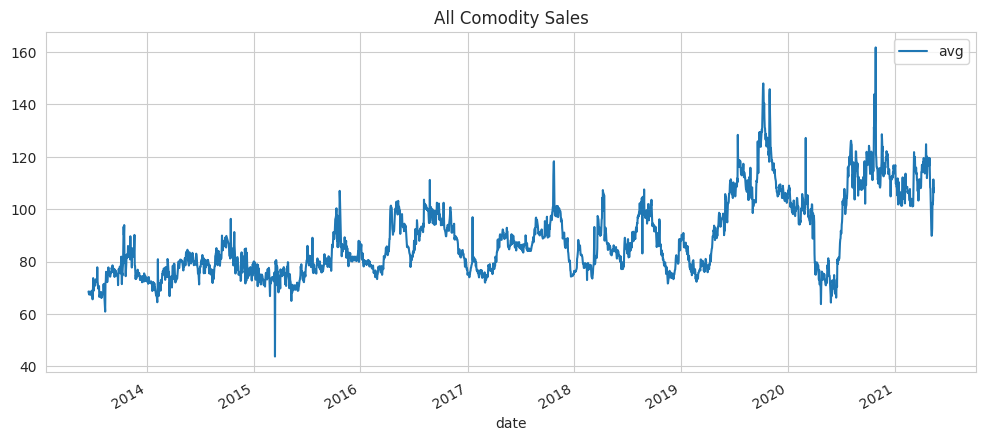

In [ ]:
data_series.plot(figsize=(12,5), title='All Comodity Sales')
plt.show()

In [ ]:
def split_data(data):
  train_size = int(len(data) * 0.8)
  train_data = data[:train_size]
  test_data = data[train_size:]

  return train_data, test_data

In [ ]:
train_data, test_data = split_data(data_series)

In [ ]:
def plot_train_test(title, train_data, test_data) :
  fig,ax = plt.subplots(figsize=(12,5))
  train_data.plot(ax=ax, label='Train Data')
  test_data.plot(ax=ax, label='Test Data')
  plt.title(f'{title} Train Test Data')
  plt.legend()
  plt.show()

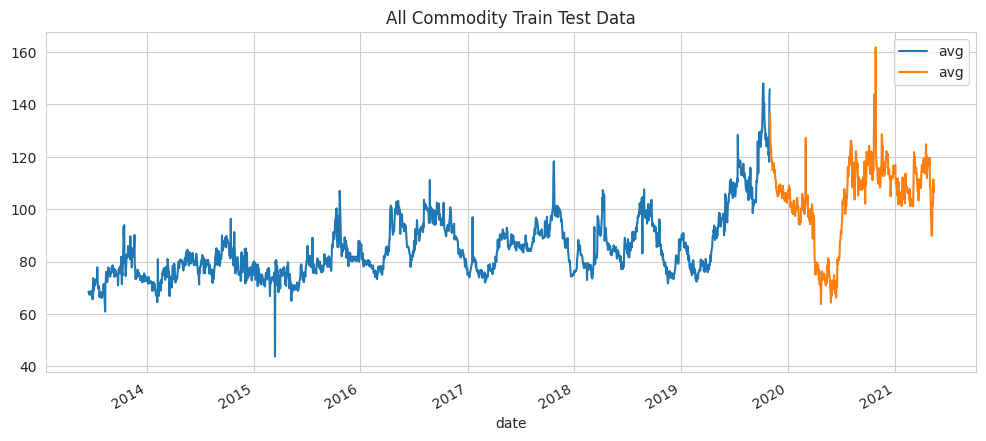

In [ ]:
plot_train_test('All Commodity', train_data, test_data)

In [ ]:
time_step = 30

#normalize data
scaler = MinMaxScaler(feature_range =(-1,1)) #minmax scaler untuk memenuhi fungsi aktivasi tangen hiperbolik default model LSTM.
train_data['avg'] = scaler.fit_transform(train_data[['avg']])
test_data['avg'] = scaler.transform(test_data[['avg']])

In [ ]:
#feature selection for lstm
def features_lstm(data, time_step=1) :
  X,y = [],[]
  for i in range(len(data)-time_step) :
    X.append(data[i:(i+time_step)])
    y.append(data[i+time_step])

  return np.array(X), np.array(y)

In [ ]:
X_train, y_train = features_lstm(train_data['avg'], time_step)
X_test, y_test = features_lstm(test_data['avg'], time_step)

#reshape data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
#modeling
# Membuat model LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(25, return_sequences=True))
lstm_model.add(LSTM(25, return_sequences=False))

lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model
lstm_model.fit(X_train, y_train, epochs=100, batch_size=42, verbose=1)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0312
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0075
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0071
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0064
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0063
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0055
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0054
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0049
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0049
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0047
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0048
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0041
Epoch 13/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0039
Epoch 14/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0032
Epoch 15/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - lo

In [ ]:
# evaluation --> ngulik metode evaluation time series
y_pred_train = lstm_model.predict(X_train)
y_pred = lstm_model.predict(X_test)

68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
#inverse pred to actual
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred = scaler.inverse_transform(y_pred)

In [ ]:
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
#mse
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred)

print(f'MSE for Train Data = {mse_train}')
print(f'MSE for Test Data = {mse_test}')

MSE for Train Data = 7.647167581227597
MSE for Test Data = 18.395166324565363


In [ ]:
train_data['avg'] = scaler.inverse_transform(train_data[['avg']])
test_data['avg'] = scaler.inverse_transform(test_data[['avg']])

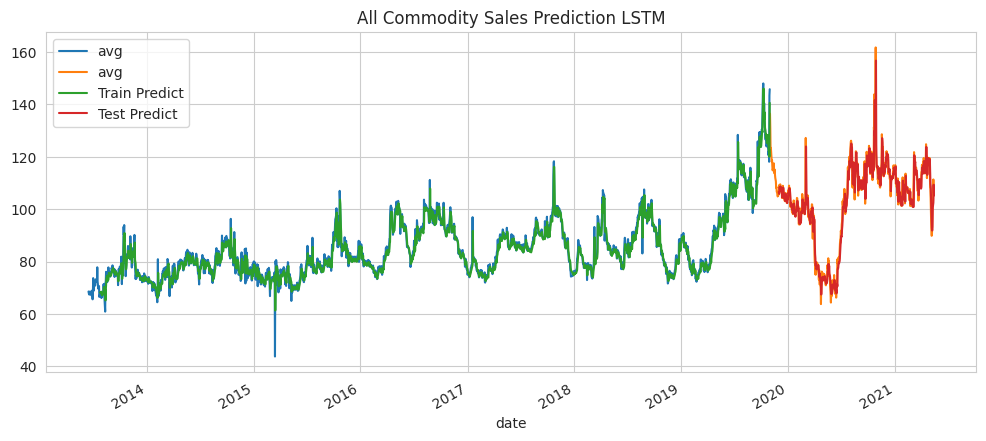

In [ ]:
#plot
fig,ax = plt.subplots(figsize=(12,5))
train_data.plot(ax=ax)
test_data.plot(ax=ax)
plt.plot(train_data['avg'].index[time_step:], y_pred_train, label='Train Predict')
plt.plot(test_data['avg'].index[time_step:], y_pred, label='Test Predict')
plt.title('All Commodity Sales Prediction LSTM')
plt.legend()
plt.show()

In [ ]:
# save model
lstm_model.save('/content/lstm_model.h5')

In [ ]:
lstm_model = load_model('/content/lstm_model.h5')

In [ ]:
last_data = data_series[-30:]

In [ ]:
last_data

,avg
date,
2021-05-13,37.5
2021-05-13,47.5
2021-05-13,47.5
2021-05-13,225.0
2021-05-13,105.0
2021-05-13,45.0
2021-05-13,47.5
2021-05-13,65.0
2021-05-13,130.0


In [ ]:
last_data_scaled = scaler.transform(last_data)

In [ ]:
input_data = last_data_scaled.reshape((1, 30 ,1))

In [ ]:
predictions = []
for i in range(30) :
  predicted_value = lstm_model.predict(input_data)
  predicted_actual = scaler.inverse_transform(predicted_value)
  predictions.append(predicted_actual[0,0])

  predicted_value_reshaped = predicted_value.reshape(1,1,1)

  input_data = np.append(input_data[:, 1:, :], predicted_value_reshaped, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━

In [ ]:

datetime.now()

datetime.datetime(2024, 8, 4, 12, 43, 35, 794658)

In [ ]:
start_date = last_data.index[-1]

In [ ]:
date = [start_date + timedelta(days=x) for x in range(1, len(predictions)+1)]

In [ ]:
df_predictions = pd.DataFrame(
    {'date' : date,
     'prediction' : predictions}
)


In [ ]:
df_predictions = df_predictions.set_index('date')

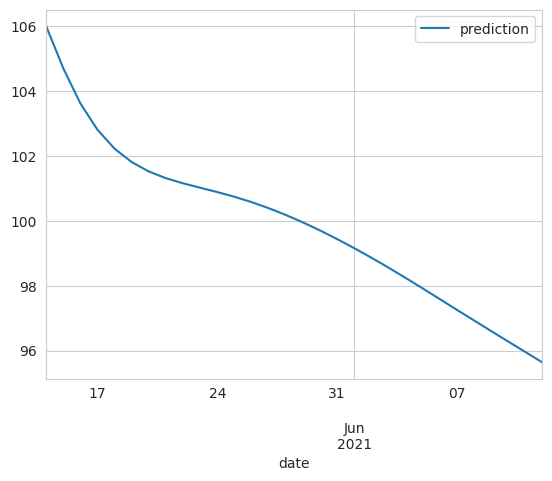

In [ ]:
df_predictions.plot()
plt.show()

#### LSTM Crossvalidation

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [ ]:
# fine tuning --> crossvalidation
X,y = features_lstm(data_series['avg'], time_step)
X = X.reshape((X.shape[0], X.shape[1],1))

In [ ]:
tss = TimeSeriesSplit(n_splits=3)
mse_scores = []

In [ ]:
for train_index, test_index in tss.split(X_train) :
  X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
  y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

    # Membuat model LSTM
  lstm_model = Sequential()
  lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
  lstm_model.add(LSTM(25, return_sequences=True))
  lstm_model.add(LSTM(25, return_sequences=False))

  lstm_model.add(Dense(25))
  lstm_model.add(Dense(1))
  lstm_model.compile(optimizer='adam', loss='mean_squared_error')

  # Melatih model
  lstm_model.fit(X_train_cv, y_train_cv, epochs=100, batch_size=42, verbose=1)

  y_pred_norm = lstm_model.predict(X_test_cv)

  y_test = scaler.inverse_transform(y_test_cv.reshape(-1,1))
  y_pred = scaler.inverse_transform(y_pred_norm)

  mse = mean_squared_error(y_test_cv, y_pred_norm)
  mse_scores.append(mse)

print(f'Mean Squared Errors for each fold: {mse_scores}')

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0691
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0065
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0065
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0064
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0066
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0061
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0054
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0063
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0065
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0072
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0052
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0046
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0059
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0059
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - lo

In [ ]:
y_pred_train = lstm_model.predict(X_train)
y_pred_test = lstm_model.predict(X_test)

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_train = scaler.inverse_transform(y_pred_train)

In [ ]:
train_data['avg'] = scaler.inverse_transform(train_data[['avg']])
test_data['avg'] = scaler.inverse_transform(test_data[['avg']])

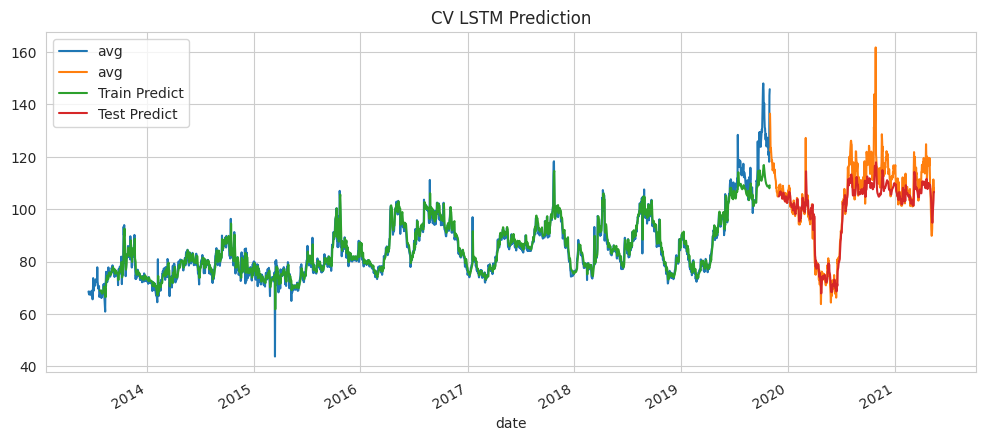

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
train_data.plot(ax=ax)
test_data.plot(ax=ax)
plt.plot(train_data.index[time_step:], y_pred_train, label = 'Train Predict')
plt.plot(test_data.index[time_step:], y_pred_test, label = 'Test Predict')
plt.title('CV LSTM Prediction')
plt.legend()
plt.show()